# IMPTOX

Apply the various procedures developped during the first year and a half to update the Gepard compatible neural network. The new neural network must be adapted to the real world sample images, that are saturated with particles. 


1. Pre-process the full-filter images to create tiles

2. Export the tiles to a chosen annotation tool (V7 - Roboflow) 

    2.1. Test the annotation using the available tools (SAM and interface) 
    
    2.2. Document the best way to annotate
    
    2.3. Enable the community annotation
    
    2.4. Test the community annotation before hiring someone
    
    
3. (moved to second notebook) Test other alternative algorithm (e.g. border detection for particle definition, as filters are saturated) 

    3.1 Border detection
    
    3.2 SAM with 25-35um squares over all the image (25 um would give too many particles as it would be the resolution of a FPA)/
    
    3.3 Other ideas ?




# Pre-processing

Importante choices: 

- only jpg files will be treated. They are all the same resolution and jpg files are highly tolerated
- the cropping will be the same for all the images and will thus be very generic. The border regions of the filter will thus often be ignored. 
- as the number of images will most likely increase, the images (tiles) names must remain unique. They will therefore be named after the experiment name (as in the harvest_images.sh script) and numbered according to the amount of images cut out from the full filter. 



In [4]:
# imports
import os
import sys

import pathlib
import glob

import matplotlib.pyplot as plt
import PIL


import numpy as np

from IPython.display import Image, display

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


import cv2


In [21]:
# paths

data_dir = "../../../0_DATA/IMPTOX"

# Contains three folders: /jpg, /bmp and /tif. 
#     The images are extracted from the raw data transmited by the FTIR team in UBFC
#     Each of these folder might contain a varying number of images
full_filter_dirs = data_dir + "/01-01_image_library/V2/0_FilesWP4/_full_filters"

full_filter_jpg = full_filter_dirs + "/jpg"
#full_filter_bmp = full_filter_dirs + "/bmp"
#full_filter_tif = full_filter_dirs + "/tif"

# Cropped images (without border and as few filter as possible)
cropped_filter_dirs = data_dir + "/01-01_image_library/V2/1_cropped_filters/"

cropped_filter_jpg = cropped_filter_dirs + "jpg/"
#cropped_filter_bmp = cropped_filter_dirs + "bmp/"
#cropped_filter_tif = cropped_filter_dirs + "tif/"


output_dir_tiles_jpg_v2 = data_dir + "/01-01_image_library/V2/2_752x480_tiles/jpg/"
#output_dir_tiles_jpg_v3 = data_dir + "/01-01_image_library/V3/2_752x480_tiles/jpg/"

In [24]:
# Verifications
os.listdir(data_dir)
print(full_filter_jpg)


../../../0_DATA/IMPTOX/01-01_image_library/V2/0_FilesWP4/_full_filters/jpg


## List images

In [25]:
# Images filenames
full_filter_jpg_list = [f for f in os.listdir(full_filter_jpg) if f.endswith('.jpg')]

# Images full relative paths
full_filter_jpg_path_list = [os.path.join(full_filter_jpg, f) for f in os.listdir(full_filter_jpg) if f.endswith('.jpg')]

print(len(full_filter_jpg_path_list))



169


## Crop images

Cut the border of the images to keep only filter (corners) and sample. 

In [26]:
# Save the cropped images with the same name + "cropped" in cropped_filter_jpg

# Setting the points for cropped image (removed margins)
(left, top, right, bottom) = (500, 550, 550, 500)

for full_filter_path in full_filter_jpg_path_list: 
    
    # File basename
    filename = os.path.basename(full_filter_path)
    
    #print("Reading image: " + full_filter_path)
    #print("Basename: " + filename)
    
    #imarray = plt.imread(full_filter_path)
    #im = PIL.Image.fromarray(imarray)
    
    im = PIL.Image.open(full_filter_path)
    
    # Size of the image in pixels (size of original image)
    x, y = im.size

    # Cropped image 
    # (It will not change original image)
    im1 = im.crop((left, top, x-right, y-bottom))
    
    im1_name = "cr_" + filename
    print(im1_name)
    im1_path = cropped_filter_jpg + im1_name
    print(im1_path)
    
    # Show image if necessary. Break to stop at first image. 
    #plt.imshow(np.asarray(im1))
    #break
    
    im1.save(im1_path, 'JPEG')
    





cr_WP4_SCH_N1_F_8_Mozaik.jpg
../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_N1_F_8_Mozaik.jpg
cr_WP4_SCH_V1_F_028_Image_light.jpg
../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_V1_F_028_Image_light.jpg
cr_WP4_SCH_V1_F_028_Image_ Dark.jpg
../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_V1_F_028_Image_ Dark.jpg
cr_WP4_SCH_M1_F_B40_Mozaik.jpg
../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_M1_F_B40_Mozaik.jpg
cr_WP4_SCH_V1_F_017_Mozaik.jpg
../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_V1_F_017_Mozaik.jpg
cr_WP4_SCH_M1_F_26_Mozaik.jpg
../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_M1_F_26_Mozaik.jpg
cr_WP4_SCH_N1_F_5_Mozaik.jpg
../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_N1_F_5_Mozaik.jpg
cr_WP3_UBFC_F_R_008_Image.jpg
../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cr

All the images are now in cropped_filter_jpg

## Cropped image MANUAL visual analysis

The cropped images are from samples varying in aspect. In this version, we want to select only images with a saturated filter, as the previous neural network should work with cleaner samples. 

In [39]:
# Manually looked at the filters to select for saturated ones. 
# ATTENTION TO CHOSE THE RIGHT OPTION

candidates_saturated = ["cr_WP4_SRB_1_FR_1_Mozaik.jpg",
              "cr_WP4_SRB_1_FR_3_Mozaik.jpg",
              "cr_WP4_SRB_1_FR_4_Mozaik.jpg",
              "cr_WP4_SRB_1_FR_5_Mozaik.jpg",
              "cr_WP4_SRB_1_FRESH_1_Mozaik.jpg", 
              "cr_WP4_SRB_1_FRESH_2_Mozaik.jpg", 
              "cr_WP4_SRB_1_FRESH_3_Mozaik.jpg", 
              "cr_WP4_SRB_1_FRESH_4_mozaik.jpg", 
              "cr_WP4_SRB_1_FRESH_5_Mozaik.jpg", 
              "cr_WP4_SRB_1_M_1_Mozaik.jpg",
              "cr_WP4_SRB_1_M_2_Mozaik.jpg",
              "cr_WP4_SRB_1_M_4_Mozaik.jpg",
              "cr_WP4_SRB_1_M_5_Mozaik.jpg",
              "cr_WP4_SRB_1_M_B6_Mosaic.jpg"]



# For the purpose of this NN version, we take all theimages, saturated or not. 
candidates = os.listdir(cropped_filter_jpg)

#-----------------------------------------------

candidates_paths = [os.path.join(cropped_filter_jpg, candidate) for candidate in candidates]

#for p in candidates_paths: 
#    print(p)

print(f"There are {len(candidates_paths)} candidates images to split into fixed-size tiles.")

There are 169 candidates images to split into fixed-size tiles.


In [40]:
candidates_paths

['../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP3_UBFC_F_R_008_Image.jpg',
 '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_V1_F_203_Image.jpg',
 '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_KOR_LIO_F_5_Mozaik.jpg',
 '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SRB_1_FR_4_Mozaik.jpg',
 '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_V1_F_024_WP4_SCH_V1_F024.jpg',
 '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_V1_F_017_Mozaik.jpg',
 '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_GK_Mc01_2Y_F_14_Image.jpg',
 '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP3_UBFC_F_T_002_Image.jpg',
 '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_M1_F_15_Mozaik.jpg',
 '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg

## Generate an save tiles 

Sliding window within the cropped image: cut fixed size tiles. In order to gain efficiency and avoid overlap, each image are only ~50 px similar on the x axis. 

With a step_size of 700px, we get 99 images. 

In [41]:
# Efficient sliding window: https://stackoverflow.com/questions/61051120/sliding-window-on-a-python-image

target_width = 752
target_height = 480
step_size = 700



def sliding_window(image, stepSize, windowSize, idx):
    for y in range(0, image.shape[0]-target_height, stepSize):
        for x in range(0, image.shape[1]-target_width, stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
            
            

def extractFeatures(output_dir_tiles, window, idx):
    # avoid windows with size not matching
    #print(window.shape)
    if window.shape != (target_height, target_width, 3):
        print(f"Ignore {idx}")
        return "Ignore window"
    else:
        # For each window, save the original, a flip and a mirror version (flip + mirror juged too much)
        im = PIL.Image.fromarray(window)
        
        # Caution global variable for path. 
        im_path = os.path.join(output_dir_tiles, f"{idx[0]}_{idx[1]}_{image_name}")
        #print(f"Saving tile at {im_path}")
        im.save(im_path)

    return "features"


Execute the sliding window

In [42]:
print(candidates_paths)

['../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP3_UBFC_F_R_008_Image.jpg', '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_V1_F_203_Image.jpg', '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_KOR_LIO_F_5_Mozaik.jpg', '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SRB_1_FR_4_Mozaik.jpg', '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_V1_F_024_WP4_SCH_V1_F024.jpg', '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_V1_F_017_Mozaik.jpg', '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_GK_Mc01_2Y_F_14_Image.jpg', '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP3_UBFC_F_T_002_Image.jpg', '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_M1_F_15_Mozaik.jpg', '../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_jpg_W

In [43]:
# Remove existing files in output_dir_tiles_jpg

# V2 contains all filters from UBFC experiments

output_dir_tiles_jpg_v2 = "../../../0_DATA/IMPTOX/01-01_image_library/V2/2_752x480_tiles/jpg/"

output_dir = output_dir_tiles_jpg_v2


folder = output_dir_tiles_jpg_v2

for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

# Create and save the tiles in output_dir_tiles_jpg

for i, image_path in enumerate(candidates_paths):
    print(f"Image path: {image_path}")
    image_name = os.path.basename(image_path)
    print(f"Image name: {image_name}")
    print(f"Image ID: {i}")
    image = plt.imread(image_path)
    features = []
    windows = sliding_window(image, step_size, (target_width, target_height), i)
    for t, window in enumerate(windows):
        extractFeatures(output_dir, window[2], (i,t))

Image path: ../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP3_UBFC_F_R_008_Image.jpg
Image name: cr_WP3_UBFC_F_R_008_Image.jpg
Image ID: 0
Image path: ../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_V1_F_203_Image.jpg
Image name: cr_WP4_SCH_V1_F_203_Image.jpg
Image ID: 1
Image path: ../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_KOR_LIO_F_5_Mozaik.jpg
Image name: cr_WP4_KOR_LIO_F_5_Mozaik.jpg
Image ID: 2
Image path: ../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SRB_1_FR_4_Mozaik.jpg
Image name: cr_WP4_SRB_1_FR_4_Mozaik.jpg
Image ID: 3
Image path: ../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_V1_F_024_WP4_SCH_V1_F024.jpg
Image name: cr_WP4_SCH_V1_F_024_WP4_SCH_V1_F024.jpg
Image ID: 4
Image path: ../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SCH_V1_F_017_Mozaik.jpg
Image name: cr_WP4_SCH_V1_F_017_Mozaik.jpg
Image ID

In [46]:
## list of tiles' paths in output_dir_tiles_jpg

paths_tiles_jpg = [f"{output_dir_tiles_jpg_v2}{tile}" for tile in os.listdir(output_dir_tiles_jpg_v2) ]
print(len(paths_tiles_jpg)) # 99 images, 1227 for v3


1227


# 3 - Tests for particles segmentation

Note: all of these idea are wrong anyway, as the number of particles will be too high for the uFTIR

- Border detection ?
- SAM ?
- Clustering ?




In [49]:
# Paths of random images

img_path_1 = "../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SRB_1_M_2_Mozaik.jpg"
img_path_2 = "../../../0_DATA/IMPTOX/01-01_image_library/V2/1_cropped_filters/jpg/cr_WP4_SRB_1_FRESH_3_Mozaik.jpg"


# UTILS



def display_ipython(path):
    # from IPython.display import Image, display
    display(PIL.Image.open(path))

    

def display_matplotlib(path):
    #import matplotlib.pyplot as plt
    #import numpy as np
    #from PIL import Image
    img = np.asarray(PIL.Image.open(path))
    imgplot = plt.imshow(img)
    return imgplot



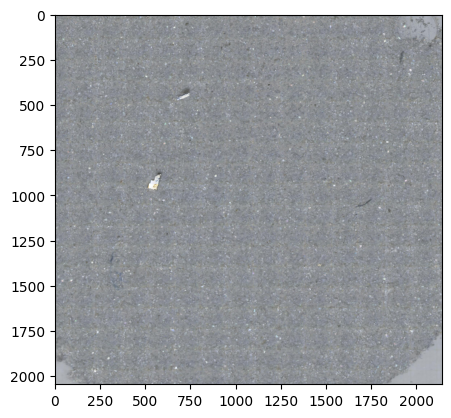

In [50]:
display_matplotlib(img_path_1)

### K-means clustering

From [here](https://www.thepythoncode.com/article/kmeans-for-image-segmentation-opencv-python). Way too inefficient and time consuming !

In [12]:
import matplotlib.pyplot as plt

# read the image
#image = cv2.imread(img_path_1)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# reshape the image to a 2D array of pixels and 3 color values (RGB)
#pixel_values = image.reshape((-1, 3))
# convert to float
#pixel_values = np.float32(pixel_values)


# define stopping criteria
#criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1, 0.2)

# number of clusters (K)
#k = 300
#_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 1, cv2.KMEANS_RANDOM_CENTERS)

# convert back to 8 bit values
#centers = np.uint8(centers)

# flatten the labels array
#labels = labels.flatten()


# convert all pixels to the color of the centroids
#segmented_image = centers[labels.flatten()]


# reshape back to the original image dimension
#segmented_image = segmented_image.reshape(image.shape)
# show the image

#fig, ax = plt.subplots(figsize=(500, 500))

#ax.imshow(segmented_image)
#plt.show()